# **AI-Powered Maestro Finder: End-to-End Composer Classification on Classical MIDI**


## **Data Wrangling and Preprocessing**

This notebook turns a raw collection of classical piano MIDIs into a clean, balanced, and model-ready dataset. We remove duplicates, clean each file, rebalance classes, and extract features used by the CNN and LSTM models. The output is a cached folder of features plus a manifest the training notebooks can load quickly:


* Gather and de-duplicate MIDIs per composer, then stage a local working copy.
* Clean each file: drop drums and empty tracks, fix note bounds to A0-C8, sanitize velocities and durations, and skip corrupted or extreme files.
* Verify counts so only unique, valid pieces move forward.
* Rebalance the dataset with light augmentation on minority classes: pitch shift, time stretch, and velocity jitter, while keeping originals.
* Extract model features for every piece:
  * A fixed 88x512 piano-roll for the CNN
  * An event-token sequence for the LSTM
  * Chord labels for analysis
* Save features and a manifest CSV so training notebooks can load data fast and reproducibly.


### **Dataset Overview**

**Source**  
[Kaggle - midi_classic_music](https://www.kaggle.com/datasets/blanderbuss/midi-classic-music)  

**Contents**

* **1 637 raw MIDI files** of well-known classical repertoire  
* Organised in four top-level folders, one per composer:  


  | Composer   | Files | Typical content |
  |------------|------:|-----------------|
  | Bach       | 1 024 | Fugues, preludes, inventions, organ works |
  | Beethoven  |   220 | Piano sonatas, symphony movements, string quartets |
  | Chopin     |   136 | Nocturnes, études, waltzes, polonaises |
  | Mozart     |   257 | Piano sonatas, symphonies, operatic excerpts |


* **MIDI format** - each file is a sequence of note-on / note-off events, velocities, channels and (sometimes) tempo or key-signature meta-events.
* **No additional metadata** (e.g., opus numbers or movement labels) is shipped; file names and folder structure are our only labels.

**Why this dataset?**

* **Style-rich but lightweight** - < 100 MB compressed, yet enough material to learn composer-style features.
* **Symbolic music** - perfect for sequence models (LSTM, Transformer) or piano-roll CNNs without audio preprocessing.
* **Open licence** - freely redistributable for coursework and demos.

We copied the archive to Google Drive—`/My Drive/Colab Notebooks/midi_classic_music/`—and ran an initial audit (file counts as shown below) before any cleaning or deduplication.


In [ ]:
# ------ Standard‑library imports ------

import hashlib
import itertools
import json
import logging
import os
import pickle
import random
import shutil
import warnings
from pathlib import Path
import csv
import pathlib

# ------ Third‑party / external packages ------

import keras_tuner as kt
import matplotlib.pyplot as plt
import miditoolkit
import music21
import numpy as np
import pandas as pd
import pretty_midi as pm
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers as L
from tqdm import tqdm

#  ------ Global warning filters ------

warnings.filterwarnings("ignore",
                        category=UserWarning,
                        module="pretty_midi")
warnings.filterwarnings("ignore",
                        category=UserWarning,
                        module="mido")
warnings.filterwarnings("ignore",
                        category=RuntimeWarning,
                        module="pretty_midi")
warnings.filterwarnings("ignore",
                        category=RuntimeWarning,
                        module="mido")
warnings.filterwarnings("ignore",
                        message="Tempo, Key or Time signature",
                        category=RuntimeWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MIDI_ROOT = Path("/content/drive/My Drive/Colab Notebooks/midi_classic_music")
assert MIDI_ROOT.exists(), f"{MIDI_ROOT} not found!"

# let's peek at the composer folders:
print([p.name for p in MIDI_ROOT.iterdir() if p.is_dir()])

['Beethoven', 'Bach', 'Chopin', 'Mozart']


In [ ]:
def iter_midis(root: Path):
    "Yield every *.mid / *.midi file, case-insensitive."
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in {".mid", ".midi"}:
            yield p

def count_midis(root: Path):
    counts = {}
    for d in root.iterdir():
        if d.is_dir():
            counts[d.name] = sum(1 for _ in iter_midis(d))
    return counts



In [ ]:
counts = count_midis(MIDI_ROOT)
pd.DataFrame(counts.items(), columns=["Composer", "MIDI files"]).sort_values("Composer")

,Composer,MIDI files
1,Bach,1024
0,Beethoven,220
2,Chopin,136
3,Mozart,257


### **Data-Cleanup**

| Step | What we did | Why it matters |
|------|-------------|----------------|
| **1. De-duplication** | Hashed every MIDI *after* stripping meta-events and flagged identical hashes. | Removes carbon-copy pieces &rarr; no leakage across train / val / test. |
| **2. Local staging** | Copied just one copy of each piece into **`/content/midi_clean/`** (Google Drive originals stay untouched). | Faster I/O in Colab and zero risk of losing the source files. |
| **3. Hygiene pass** &rarr; **`/content/midi_ready/`** | For every file:<br>▪ dropped drum/empty tracks<br>▪ fixed overlaps & capped sustain &le; 20 s<br>▪ clamped pitches to A0-C8<br>▪ skipped ultra-tiny or gigantic pieces<br>▪ if `pretty_midi` choked, raw-copied the file instead | Ensures the model sees only well-formed, musically plausible data—and never crashes on a bad MIDI. |
| **4. Verification** | Compared Drive vs. cleaned counts:<br> `cleaned = original - duplicate_copies - filtered_out` | Confirms we lost nothing except intentional drops. |

**Resulting counts (unique, cleaned)**

| Composer | Original | Cleaned | Removed\* |
|----------|---------:|--------:|----------:|
| Bach      | 1 024 | **984** | 40 |
| Beethoven | 220   | **161** | 59 |
| Chopin    | 136   | **128** | 8 |
| Mozart    | 257   | **216** | 41 |

\*`Removed = duplicates skipped + files discarded by hygiene rules.`  

Only these **unique, cleaned files** are now in `midi_ready/`; they're the ones the LSTM/CNN pipeline will consume.


In [ ]:
# ----- helpers -----
def iter_midis(root: Path):
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in {".mid", ".midi"}:
            yield p

def canonical_or_raw_bytes(fp: Path) -> bytes:
    try:
        m = pm.PrettyMIDI(str(fp))
        m.time_signature_changes = []
        m.key_signature_changes  = []
        buf = io.BytesIO(); m.write(buf)
        return buf.getvalue()
    except Exception as e:
        #print(f"[warn] {fp.name}: {type(e).__name__} – using raw bytes")
        return fp.read_bytes()

def md5_midi(fp: Path) -> str:
    return hashlib.md5(canonical_or_raw_bytes(fp)).hexdigest()

def find_exact_dupes(folder: Path):
    hashes = {}
    for midi in iter_midis(folder):
        h = md5_midi(midi)
        hashes.setdefault(h, []).append(midi)
    return {h: g for h, g in hashes.items() if len(g) > 1}

# ----- scan every composer -----
rows = []
for composer_dir in MIDI_ROOT.iterdir():
    if composer_dir.is_dir():
        dupes  = find_exact_dupes(composer_dir)
        extras = sum(len(g) - 1 for g in dupes.values())
        rows.append({
            "Composer": composer_dir.name,
            "Total files": sum(1 for _ in iter_midis(composer_dir)),
            "Duplicate groups": len(dupes),
            "Duplicate copies": extras,
        })

pd.DataFrame(rows).sort_values("Composer")


,Composer,Total files,Duplicate groups,Duplicate copies
1,Bach,1024,10,10
0,Beethoven,220,5,5
2,Chopin,136,4,4
3,Mozart,257,2,2


In [ ]:
LOCAL_ROOT   = Path("/content/midi_clean")
LOCAL_ROOT.mkdir(exist_ok=True)

dupes = find_exact_dupes(MIDI_ROOT)
dupe_hashes = {fp for g in dupes.values() for fp in g[1:]}

for src in iter_midis(MIDI_ROOT):
    rel = src.relative_to(MIDI_ROOT)
    dst = LOCAL_ROOT / rel
    dst.parent.mkdir(parents=True, exist_ok=True)

    # copy everything except the extra duplicates
    if src in dupe_hashes:
        continue
    shutil.copy2(src, dst)


In [ ]:
def count_midis_local(root):
    return {d.name: sum(1 for _ in iter_midis(d))
            for d in root.iterdir() if d.is_dir()}

print("Drive counts :", {k: v for k, v in count_midis(MIDI_ROOT).items()})
print("Local counts :", {k: v for k, v in count_midis_local(LOCAL_ROOT).items()})

Drive counts : {'Beethoven': 220, 'Bach': 1024, 'Chopin': 136, 'Mozart': 257}
Local counts : {'Beethoven': 215, 'Chopin': 132, 'Bach': 1014, 'Mozart': 255}


In [ ]:
SRC  = Path("/content/midi_clean")
DEST = Path("/content/midi_ready")
DEST.mkdir(exist_ok=True)

def safe_clean_copy(src_fp: Path, dst_fp: Path):
    """Try to clean/wipe; if PrettyMIDI chokes, just copy raw bytes."""
    try:
        m = pm.PrettyMIDI(str(src_fp))

        # drop empty or drum tracks
        m.instruments = [i for i in m.instruments if i.notes and not i.is_drum]

        # basic note hygiene
        m.remove_invalid_notes()
        for inst in m.instruments:
            for n in inst.notes:
                n.end   = min(n.end, n.start + 20.0)
                n.pitch = max(21, min(108, n.pitch))

        # size filter
        total = sum(len(i.notes) for i in m.instruments)
        if not (100 <= total <= 10_000):
            return

        dst_fp.parent.mkdir(parents=True, exist_ok=True)
        m.write(str(dst_fp))
    except Exception as e:
        # fallback: raw copy so we don’t lose the piece
        dst_fp.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(src_fp, dst_fp)



In [ ]:
# helper: case-insensitive MIDI iterator:
def iter_midis(root: Path):
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in {".mid", ".midi"}:
            yield p

# run the clean / fallback-copy pass:
for src in iter_midis(SRC):
    rel = src.relative_to(SRC)
    safe_clean_copy(src, DEST / rel)

print("Cleaned files written to", DEST)

Cleaned files written to /content/midi_ready


In [ ]:
READY_ROOT = Path("/content/midi_ready")     # cleaned dataset

def count_midis(root: Path):
    return {d.name: sum(1 for _ in iter_midis(d))
            for d in root.iterdir() if d.is_dir()}

ready_counts = count_midis(READY_ROOT)

pd.DataFrame(
    ready_counts.items(),
    columns=["Composer", "Cleaned files"]
).sort_values("Composer")

,Composer,Cleaned files
2,Bach,984
0,Beethoven,161
1,Chopin,128
3,Mozart,216


In [ ]:
orig_counts  = count_midis(MIDI_ROOT)        # Drive copy
summary = pd.DataFrame([
    {
        "Composer": k,
        "Original": orig_counts.get(k, 0),
        "Cleaned":  ready_counts.get(k, 0),
    }
    for k in sorted(orig_counts.keys())
])
summary["Difference"] = summary["Original"] - summary["Cleaned"]
summary


,Composer,Original,Cleaned,Difference
0,Bach,1024,984,40
1,Beethoven,220,161,59
2,Chopin,136,128,8
3,Mozart,257,216,41


### **Augmentation**

To balance the heavily skewed class distribution (Bach &asymp; 1 k files vs. 160-260 for the others) we expand only the **minority composers**—Beethoven, Chopin, Mozart—until each class reaches **984 MIDIs**.  
The cleaned originals live in `/content/midi_ready/`; augmented copies go to `/content/midi_aug/`.

| Augment type | What we do | Tag in filename | Why |
|--------------|------------|-----------------|-----|
| **Pitch-shift** | Transpose  &plusmn;1 & &plusmn;2 semitones (keep notes within A0-C8). | ps&plusmn;1, ps&plusmn;2 | Adds key diversity while preserving interval structure. |
| **Time-stretch** | Scale note start/end by 0.95 x or 1.05 x. | `ts95`, `ts105` | Simulates natural tempo rubato. |
| **Velocity jitter** | Add &plusmn;10 MIDI units of random noise to velocities. | `vj` | Mimics dynamic nuance. |

In [ ]:
SRC  = Path("/content/midi_ready")            # cleaned originals
AUG  = Path("/content/midi_aug")              # new + originals
AUG.mkdir(exist_ok=True)

TARGET = 984   # per composer to make it even

def save_variant(midi, dst, tag):
    dst = dst.with_name(dst.stem + f"_{tag}.mid")
    midi.write(str(dst))

def augment_piece(src_fp: Path, composer_dir: Path):
    m = pm.PrettyMIDI(str(src_fp))
    base = composer_dir / src_fp.name         # copy original
    shutil.copy2(src_fp, base)

    # pitch shifts +/-1, +/-2:
    for n in [-2, -1, 1, 2]:
        copy = pm.PrettyMIDI(str(src_fp))
        for inst in copy.instruments:
            for note in inst.notes:
                note.pitch = np.clip(note.pitch + n, 21, 108)
        save_variant(copy, base, f"ps{n}")

    # time-stretch +/-5 %:
    for fac in [0.95, 1.05]:
        copy = pm.PrettyMIDI(str(src_fp))
        for inst in copy.instruments:
            for note in inst.notes:
                note.start *= fac; note.end *= fac
        save_variant(copy, base, f"ts{int(fac*100)}")

    # velocity jitter:
    copy = pm.PrettyMIDI(str(src_fp))
    for inst in copy.instruments:
        for note in inst.notes:
            note.velocity = int(np.clip(note.velocity + np.random.randint(-10,11), 0, 127))
    save_variant(copy, base, "vj")




In [ ]:
# run per minority composer until each hits 984 MIDIs:
for comp in ["Beethoven", "Chopin", "Mozart"]:
    src_dir = SRC / comp
    dst_dir = AUG / comp
    dst_dir.mkdir(parents=True, exist_ok=True)

    originals = list(src_dir.glob("*.mid"))
    for fp in originals:
        try:
            augment_piece(fp, dst_dir)
        except Exception as e:
            # fallback-copy the original so we don't lose the piece
            shutil.copy2(fp, dst_dir / fp.name)

        # stop once we hit the target:
        if len(list(dst_dir.glob("*.mid"))) >= TARGET:
            break

In [ ]:
AUG_ROOT = Path("/content/midi_aug")   # folder with originals + variants

def iter_midis(root):
    for p in root.rglob("*"):
        if p.suffix.lower() in {".mid", ".midi"} and p.is_file():
            yield p

def count_midis(root):
    return {
        d.name: sum(1 for _ in iter_midis(d))
        for d in root.iterdir() if d.is_dir()
    }

# file counts:
aug_counts = count_midis(AUG_ROOT)
pd.DataFrame(
    aug_counts.items(),
    columns=["Composer", "Files in midi_aug"]
).sort_values("Composer")

,Composer,Files in midi_aug
0,Beethoven,985
1,Chopin,984
2,Mozart,984


In [ ]:

root = pathlib.Path("/content/midi_aug")

with open("/content/midi_manifest.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["path", "label"])
    for comp_dir in root.iterdir():
        for fp in comp_dir.glob("*.mid"):
            writer.writerow([str(fp), comp_dir.name])

In [ ]:
root = Path("/content/midi_aug")

sample_paths = random.sample(list(root.rglob("*.mid")), 5)
for fp in sample_paths:
    m = pm.PrettyMIDI(str(fp))
    print(f"{fp.name:40s}  | notes: {sum(len(i.notes) for i in m.instruments)}")

Sonatina In C.mid                         | notes: 2854
Prelude n13 op28 ''Loss''_ps2.mid         | notes: 904
Bagatella op33 n4_ps-1.mid                | notes: 1074
K626 Requiem 01 Introitus & Kyrie_ts105.mid  | notes: 9819
Sonata Opus.81a -Les Adieux- E flat No.2 & 3_ps1.mid  | notes: 6228


In [ ]:
def show_roll(midi_path, fs=8, max_frames=512):
    m      = pm.PrettyMIDI(str(midi_path))
    roll   = (m.get_piano_roll(fs=fs) > 0).T[:, 21:109]    # (time, 88)
    roll   = roll[:max_frames]                             # crop
    roll   = roll.T                                        # (88, time) for plotting

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.imshow(
        roll,
        cmap="gray_r",               # high contrast
        aspect="auto",
        origin="lower",
        interpolation="nearest"      # crisp pixels
    )

    # put a faint vertical bar every bar (32 frames at fs=8, 4/4):
    for x in range(0, max_frames, 32):
        ax.axvline(x, color="white", lw=0.3, alpha=0.3)

    ax.set_yticks([0, 21, 40, 60, 80])
    ax.set_yticklabels(["A0", "C2", "E3", "A4", "C6"])
    ax.set_xlabel("Time frames   (8 frames ≈ 1 beat)")
    ax.set_ylabel("Pitch")
    ax.set_title(Path(midi_path).name)
    plt.tight_layout()
    plt.show()

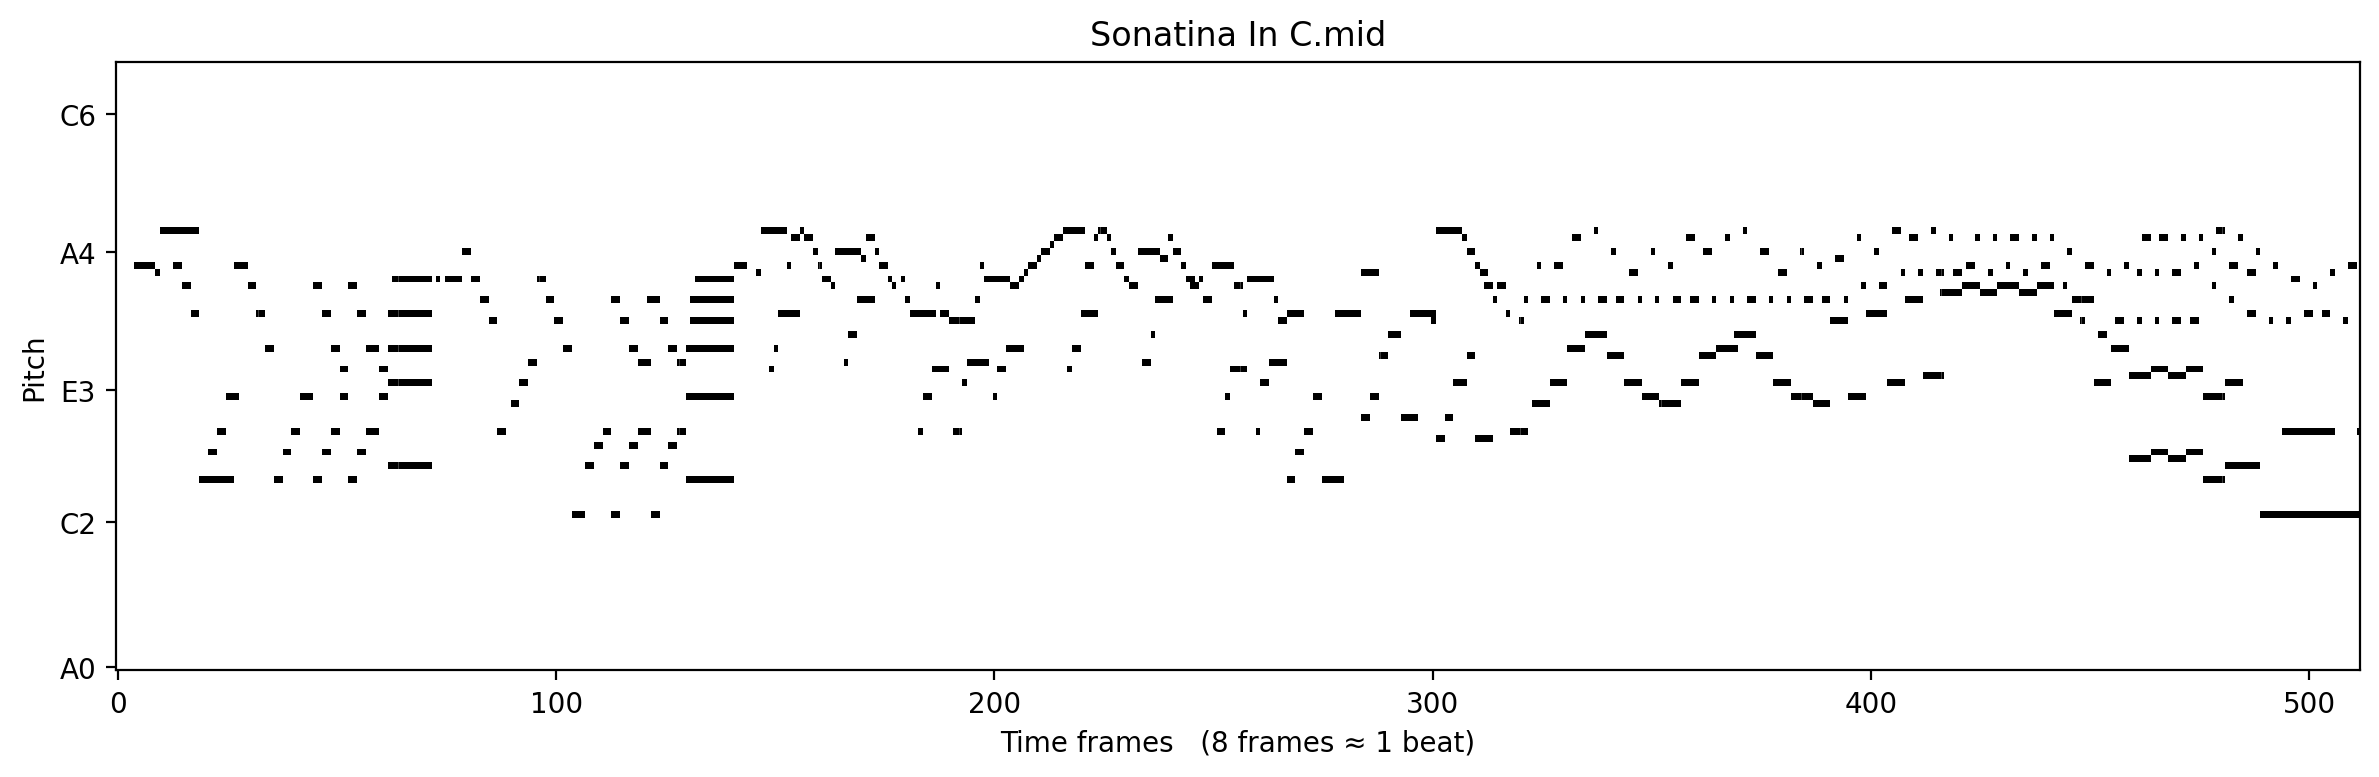

In [ ]:
show_roll(sample_paths[0])

In [ ]:
AUG_ROOT = Path("/content/midi_aug")

def iter_midis(root):
    for p in root.rglob("*"):
        if p.suffix.lower() in {".mid", ".midi"} and p.is_file():
            yield p

def count_midis(root):
    return {
        d.name: sum(1 for _ in iter_midis(d))
        for d in root.iterdir() if d.is_dir()
    }

pd.DataFrame(count_midis(AUG_ROOT).items(),
             columns=["Composer", "Files"]).sort_values("Composer")


,Composer,Files
0,Beethoven,985
1,Chopin,984
2,Mozart,984


In [ ]:
ready_bach = Path("/content/midi_ready/Bach")     # cleaned originals
aug_bach   = Path("/content/midi_aug/Bach")       # target
aug_bach.mkdir(parents=True, exist_ok=True)

# copy every .mid / .MID file just once:
for fp in ready_bach.rglob("*"):
    if fp.suffix.lower() in {".mid", ".midi"} and fp.is_file():
        shutil.copy2(fp, aug_bach / fp.name)

print("Bach copied:", len(list(aug_bach.glob('*.mid'))) +
                       len(list(aug_bach.glob('*.MID'))), "files")

Bach copied: 984 files


In [ ]:
root = Path("/content/midi_aug")

def iter_midis(p):
    for f in p.rglob("*"):
        if f.suffix.lower() in {".mid", ".midi"} and f.is_file():
            yield f

def count_midis(p):
    return {d.name: sum(1 for _ in iter_midis(d))
            for d in p.iterdir() if d.is_dir()}

pd.DataFrame(count_midis(root).items(),
             columns=["Composer", "Files"]).sort_values("Composer")

,Composer,Files
2,Bach,984
0,Beethoven,985
1,Chopin,984
3,Mozart,984


### **Feature extraction for modeling**

This step turns each cleaned MIDI into three compact feature files and a manifest. The goal is fast, repeatable loading for the CNN and LSTM notebooks.

**Features:**

* **Piano-roll**: Binary 88-key roll at 8 frames per second, fixed to **512 time steps**. Shape on disk: `(512, 88)` saved as `.pr.npy`.  Used by the CNN.

* **Event tokens**: A tiny, integer vocabulary that encodes timing and notes:
  * time shifts in 10 ms steps
  *  note on
  *  note off  
  * Truncated to **2048 tokens**. Saved as `.ev.json`. Used by the LSTM.

* **Chord labels**: Robust chord names from a chordified score. Falls back to `N` if unknown. Saved as `.ch.pkl`. Used for analysis and sanity checks.

* **Feature manifest**: A CSV row per piece with its stem path and composer.  Lets training notebooks scan features without rewalking folders.

**Plan:**

* **Set constants and folders**: Define the dataset root, a cache directory for features, and the formats: frames per second, sequence length for the roll, and max token length.

* **Build the piano-roll**: Read the MIDI, convert to a piano-roll, keep pitches A0-C8, then crop or pad to exactly 512 steps. Store as unsigned bytes to keep files small.

* **Build the event sequence**: Walk notes in start-time order. Insert time-shift tokens to cover the gap from the last event, then emit note-on and note-off for the pitch. Cap the sequence at 2048 tokens.

* **Extract chords**: Parse with `music21`, chordify, collect friendly chord names. If parsing fails, return a single `N`.

* **Iterate and cache**: Scan all MIDIs, create a stable stem per composer in the cache, and **skip work if the `.pr.npy` already exists**. Save all three feature files and append one line to the manifest.

* **Result**: A cache tree like `feat_cache/composer/stem.{pr.npy, ev.json, ch.pkl}` plus `feature_manifest.csv` for the training notebooks.



In [ ]:
import traceback

DATA_ROOT = Path("/content/midi_aug")          # balanced dataset
CACHE_DIR = Path("/content/feat_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

FS, SEQ_LEN, MAX_EVENTS = 8, 512, 2048

# ------------------------- Helper piano‑roll -------------------------
def piano_roll(path: Path):
    m = pm.PrettyMIDI(str(path))
    roll = (m.get_piano_roll(fs=FS) > 0).T[:, 21:109]       # (t, 88)
    # crop / pad
    roll = roll[:SEQ_LEN] if len(roll) >= SEQ_LEN else \
           np.vstack([roll, np.zeros((SEQ_LEN-len(roll), 88), np.uint8)])
    return roll.astype(np.uint8)

# ------------------------- Helper event tokens (very small vocab) -------------------------
NOTE_ON, NOTE_OFF, TIME_SHIFT = 0, 128, 256
STEP_MS, MAX_SHIFT = 10, 100

def events_from_midi(path: Path):
    m = miditoolkit.MidiFile(str(path))
    notes = sorted(m.instruments[0].notes, key=lambda n: n.start)
    ev, t = [], 0
    for n in notes:
        delta = int((n.start - t) * 1000 // STEP_MS)
        while delta > 0:
            shift = min(delta, MAX_SHIFT-1)
            ev.append(TIME_SHIFT + shift)
            delta -= shift
        ev += [NOTE_ON + n.pitch, NOTE_OFF + n.pitch]
        t = n.end
    return ev[:MAX_EVENTS]

# ------------------------- Helper chords (robust) -------------------------
def chords_from_midi(path: Path):
    try:
        s = music21.converter.parse(str(path))
        return [c.commonName or "N"
                for c in s.chordify().recurse().getElementsByClass("Chord")] or ["N"]
    except Exception:
        return ["N"]

# ------------------------- Build a flat list of all MIDI paths -------------------------
all_midis = [p for p in DATA_ROOT.rglob("*.mid") if p.is_file()]

manifest = []
for fp in tqdm.tqdm(all_midis, desc="Feature extracting", unit="file"):
    comp = fp.parent.name                # assuming /composer/file.mid
    stem = CACHE_DIR / comp / fp.stem
    stem.parent.mkdir(parents=True, exist_ok=True)

    # skip if features already exist
    if stem.with_suffix(".pr.npy").exists():
        continue

    try:
        pr = piano_roll(fp)
        ev = events_from_midi(fp)
        ch = chords_from_midi(fp)

        np.save(stem.with_suffix(".pr.npy"), pr)
        json.dump(ev, open(stem.with_suffix(".ev.json"), "w"))
        pickle.dump(ch, open(stem.with_suffix(".ch.pkl"), "wb"))

        manifest.append({"stem": str(stem), "composer": comp})
    except Exception as e:
        # log once, skip file, continue
        #print(f"[warn] {fp.name} skipped: {type(e).__name__}")
        #traceback.print_exc(limit=1)
        continue




Feature extracting:  29%|██▉       | 1127/3841 [2:36:56<1:51:46,  2.47s/file]/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'\xa9 1996'>; getting generic Instrument
  warnings.warn(
Feature extracting:  77%|███████▋  | 2961/3841 [4:03:10<2:27:31, 10.06s/file]/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, channel=None, data=b'Ba\xdf'>; getting generic Instrument
  warnings.warn(
Feature extracting: 100%|██████████| 3841/3841 [6:42:54<00:00,  6.29s/file]


## **Save features and manifest for training**


This step packages the processed dataset so the modeling notebooks can load it fast and consistently. We write all extracted features to a cache folder and a single manifest CSV, copy them to persistent storage, and verify the counts per composer. This creates a stable snapshot that both the CNN and LSTM notebooks will use.



In [ ]:
# ----------------- Save manifest -----------------
with open("/content/feature_manifest.csv", "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["stem", "composer"])
    w.writeheader(); w.writerows(manifest)

print(f"\n Cached features for {len(manifest)} pieces --> {CACHE_DIR}")
print("Manifest: /content/feature_manifest.csv")


 Cached features for 3430 pieces --> /content/feat_cache
Manifest: /content/feature_manifest.csv


In [ ]:
drive_root   = Path("/content/drive/My Drive/maestro_data")
drive_root.mkdir(parents=True, exist_ok=True)

# copy the cache folder:
src_cache = Path("/content/feat_cache")
dst_cache = drive_root / "feat_cache"
if dst_cache.exists():
    shutil.rmtree(dst_cache)
shutil.copytree(src_cache, dst_cache)

# copy the manifest CSV:
shutil.copy2("/content/feature_manifest.csv",
             drive_root / "feature_manifest.csv")

print("Everything saved under", drive_root)


Everything saved under /content/drive/My Drive/maestro_data


In [ ]:
root = Path("/content/drive/My Drive/maestro_data")
print("Contents of maestro_data: ")
for p in root.iterdir():
    print("  ", p.name)

Contents of maestro_data: 
   feat_cache
   feature_manifest.csv


In [ ]:
!ls -lh "/content/drive/My Drive/maestro_data"


total 208K
drwx------ 6 root root 4.0K Jul 28 01:43 feat_cache
-rw------- 1 root root 204K Jul 28 04:41 feature_manifest.csv


In [ ]:
!ls -lh "/content/drive/My Drive/maestro_data/feat_cache"

total 16K
drwx------ 2 root root 4.0K Jul 28 01:43 Bach
drwx------ 2 root root 4.0K Jul 28 00:25 Beethoven
drwx------ 2 root root 4.0K Jul 28 01:14 Chopin
drwx------ 2 root root 4.0K Jul 28 04:39 Mozart


In [ ]:
# Root of the cache just copied:
FEAT_ROOT = Path("/content/drive/My Drive/maestro_data/feat_cache")

rows = []
for comp_dir in FEAT_ROOT.iterdir():
    if comp_dir.is_dir():
        n = len(list(comp_dir.glob("*.pr.npy")))   # count the .pr.npy files
        rows.append({"Composer": comp_dir.name, "Cached files": n})

pd.DataFrame(rows).sort_values("Composer")

,Composer,Cached files
2,Bach,863
0,Beethoven,861
1,Chopin,736
3,Mozart,970
